In [1]:
import netCDF4 as nc
import random
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import mean_squared_error

In [2]:
# 固定随机种子
SEED = 22

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(SEED)


In [3]:
# 查看CUDA是否可用
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


In [4]:
# 读取数据

# 存放数据的路径
path = '/kaggle/input/ninoprediction/'
soda_train = nc.Dataset(path + 'SODA_train.nc')
soda_label = nc.Dataset(path + 'SODA_label.nc')
cmip_train = nc.Dataset(path + 'CMIP_train.nc')
cmip_label = nc.Dataset(path + 'CMIP_label.nc')


In [5]:
def make_flatted(train_ds, label_ds, info, start_idx=0):
    # 只使用sst特征
    keys = ['sst']
    label_key = 'nino'
    # 年数
    years = info[1]
    # 模式数
    models = info[2]
    
    train_list = []
    label_list = []
    
    # 将同种模式下的数据拼接起来
    for model_i in range(models):
        blocks = []
        
        # 对每个特征，取每条数据的前12个月进行拼接，只使用lon值在[90, 330]范围内的数据
        for key in keys:
            block = train_ds[key][start_idx + model_i * years: start_idx + (model_i + 1) * years, :12, :, 19: 67].reshape(-1, 24, 48, 1).data
            blocks.append(block)
        
        # 将所有特征在最后一个维度上拼接起来
        train_flatted = np.concatenate(blocks, axis=-1)
        
        # 取12-23月的标签进行拼接，注意加上最后一年的最后12个月的标签（与最后一年12-23月的标签共同构成最后一年前12个月的预测目标）
        label_flatted = np.concatenate([
            label_ds[label_key][start_idx + model_i * years: start_idx + (model_i + 1) * years, 12: 24].reshape(-1).data,
            label_ds[label_key][start_idx + (model_i + 1) * years - 1, 24: 36].reshape(-1).data
        ], axis=0)
        
        train_list.append(train_flatted)
        label_list.append(label_flatted)
        
    return train_list, label_list


In [6]:
soda_info = ('soda', 100, 1)
cmip6_info = ('cmip6', 151, 15)
cmip5_info = ('cmip5', 140, 17)

soda_trains, soda_labels = make_flatted(soda_train, soda_label, soda_info)
cmip6_trains, cmip6_labels = make_flatted(cmip_train, cmip_label, cmip6_info)
cmip5_trains, cmip5_labels = make_flatted(cmip_train, cmip_label, cmip5_info, cmip6_info[1]*cmip6_info[2])

# 得到扁平化后的数据维度为（模式数×序列长度×纬度×经度×特征数），其中序列长度=年数×12
np.shape(soda_trains), np.shape(cmip6_trains), np.shape(cmip5_trains)


((1, 1200, 24, 48, 1), (15, 1812, 24, 48, 1), (17, 1680, 24, 48, 1))

In [7]:
# 填充SODA数据中的空值
soda_trains = np.array(soda_trains)
soda_trains_nan = np.isnan(soda_trains)
soda_trains[soda_trains_nan] = 0
print('Number of null in soda_trains after fillna:', np.sum(np.isnan(soda_trains)))


Number of null in soda_trains after fillna: 0


In [8]:
# 填充CMIP6数据中的空值
cmip6_trains = np.array(cmip6_trains)
cmip6_trains_nan = np.isnan(cmip6_trains)
cmip6_trains[cmip6_trains_nan] = 0
print('Number of null in cmip6_trains after fillna:', np.sum(np.isnan(cmip6_trains)))


Number of null in cmip6_trains after fillna: 0


In [9]:
# 填充CMIP5数据中的空值
cmip5_trains = np.array(cmip5_trains)
cmip5_trains_nan = np.isnan(cmip5_trains)
cmip5_trains[cmip5_trains_nan] = 0
print('Number of null in cmip6_trains after fillna:', np.sum(np.isnan(cmip5_trains)))


Number of null in cmip6_trains after fillna: 0


In [29]:
# 构造训练集

X_train = []
y_train = []
# 从CMIP5的17种模式中各抽取100条数据
for model_i in range(17):
    samples = np.random.choice(cmip5_trains.shape[1]-38, size=100)
    for ind in samples:
        X_train.append(cmip5_trains[model_i, ind: ind+38])
        y_train.append(cmip5_labels[model_i][ind: ind+24])
# 从CMIP6的15种模式种各抽取100条数据
for model_i in range(15):
    samples = np.random.choice(cmip6_trains.shape[1]-38, size=100)
    for ind in samples:
        X_train.append(cmip6_trains[model_i, ind: ind+38])
        y_train.append(cmip6_labels[model_i][ind: ind+24])
X_train = np.array(X_train)
y_train = np.array(y_train)


In [11]:
# 构造测试集

X_valid = []
y_valid = []
samples = np.random.choice(soda_trains.shape[1]-38, size=100)
for ind in samples:
    X_valid.append(soda_trains[0, ind: ind+38])
    y_valid.append(soda_labels[0][ind: ind+24])
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)


In [12]:
# 查看数据集维度
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape


((3200, 38, 24, 48, 1), (3200, 24), (100, 38, 24, 48, 1), (100, 24))

In [13]:
# 保存数据集
np.save('X_train_sample.npy', X_train)
np.save('y_train_sample.npy', y_train)
np.save('X_valid_sample.npy', X_valid)
np.save('y_valid_sample.npy', y_valid)


# 模型构建

In [14]:
# 读取数据集
X_train = np.load('/kaggle/working/X_train_sample.npy')
y_train = np.load('/kaggle/working/y_train_sample.npy')
X_valid = np.load('/kaggle/working/X_valid_sample.npy')
y_valid = np.load('/kaggle/working/y_valid_sample.npy')
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape


((3200, 38, 24, 48, 1), (3200, 24), (100, 38, 24, 48, 1), (100, 24))

In [15]:
# 构造数据管道
class AIEarthDataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


In [16]:
batch_size = 2

trainset = AIEarthDataset(X_train, y_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

validset = AIEarthDataset(X_valid, y_valid)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)


In [17]:
def rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_pred = y_preds, y_true = y_true))

# 评估函数
def score(y_true, y_preds):
    # 相关性技巧评分
    accskill_score = 0
    # RMSE
    rmse_scores = 0
    a = [1.5] * 4 + [2] * 7 + [3] * 7 + [4] * 6
    y_true_mean = np.mean(y_true, axis=0)
    y_pred_mean = np.mean(y_preds, axis=0)
    for i in range(24):
        fenzi = np.sum((y_true[:, i] - y_true_mean[i]) * (y_preds[:, i] - y_pred_mean[i]))
        fenmu = np.sqrt(np.sum((y_true[:, i] - y_true_mean[i])**2) * np.sum((y_preds[:, i] - y_pred_mean[i])**2))
        cor_i = fenzi / fenmu
        accskill_score += a[i] * np.log(i+1) * cor_i
        rmse_score = rmse(y_true[:, i], y_preds[:, i])
        rmse_scores += rmse_score
    return 2/3.0 * accskill_score - rmse_scores


## attention机制

In [18]:
# Attention机制
def attn(query, key, value):
    # query、key、value的形状都是(N, C, H*W)，令S=H*W
    # 采用缩放点积模型计算得分，scores(i)=key(i)^T query/根号C
    scores = torch.matmul(query.transpose(1, 2), key / math.sqrt(query.size(1)))  # (N, S, S)
    # 计算注意力得分
    attn = F.softmax(scores, dim=-1)
    output = torch.matmul(attn, value.transpose(1, 2))  # (N, S, C)
    return output.transpose(1, 2)  # (N, C, S)


## SAM模块

In [19]:
# SAM模块
class SAAttnMem(nn.Module):
    def __init__(self, input_dim, d_model, kernel_size):
        super().__init__()
        pad = kernel_size[0] // 2, kernel_size[1] // 2
        self.d_model = d_model
        self.input_dim = input_dim
        # 用1*1卷积实现全连接操作WhHt
        self.conv_h = nn.Conv2d(input_dim, d_model*3, kernel_size=1)
        # 用1*1卷积实现全连接操作WmMt-1
        self.conv_m = nn.Conv2d(input_dim, d_model*2, kernel_size=1)
        # 用1*1卷积实现全连接操作Wz[Zh,Zm]
        self.conv_z = nn.Conv2d(d_model*2, d_model, kernel_size=1)
        # 注意输出维度和输入维度要保持一致，都是input_dim
        self.conv_output = nn.Conv2d(input_dim+d_model, input_dim*3, kernel_size=kernel_size, padding=pad)
        
    def forward(self, h, m):
        # self.conv_h(h)得到WhHt，将其在dim=1上划分成大小为self.d_model的块，每一块的形状就是(N, d_model, H, W)，所得到的三块就是Qh、Kh、Vh
        hq, hk, hv = torch.split(self.conv_h(h), self.d_model, dim=1)
        # 同样的方法得到Km和Vm
        mk, mv = torch.split(self.conv_m(m), self.d_model, dim=1)
        N, C, H, W = hq.size()
        # 通过自注意力机制得到Zh
        Zh = attn(hq.view(N, C, -1), hk.view(N, C, -1), hv.view(N, C, -1))  # (N, C, S), C=d_model
        # 通过注意力机制得到Zm
        Zm = attn(hq.view(N, C, -1), mk.view(N, C, -1), mv.view(N, C, -1))  # (N, C, S), C=d_model
        # 将Zh和Zm拼接起来，并进行全连接操作得到聚合特征Z
        Z = self.conv_z(torch.cat([Zh.view(N, C, H, W), Zm.view(N, C, H, W)], dim=1))  # (N, C, H, W), C=d_model
        # 计算i't、g't、o't
        i, g, o = torch.split(self.conv_output(torch.cat([Z, h], dim=1)), self.input_dim, dim=1)  # (N, C, H, W), C=input_dim
        i = torch.sigmoid(i)
        g = torch.tanh(g)
        # 得到更新后的记忆单元Mt
        m_next = i * g + (1 - i) * m
        # 得到更新后的隐藏状态Ht
        h_next = torch.sigmoid(o) * m_next
        return h_next, m_next


In [20]:
# SA-ConvLSTM Cell
class SAConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_attn, kernel_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        pad = kernel_size[0] // 2, kernel_size[1] // 2
        # 卷积操作Wx*Xt+Wh*Ht-1
        self.conv = nn.Conv2d(in_channels=input_dim+hidden_dim, out_channels=4*hidden_dim, kernel_size=kernel_size, padding=pad)
        self.sa = SAAttnMem(input_dim=hidden_dim, d_model=d_attn, kernel_size=kernel_size)
        
    def initialize(self, inputs):
        device = inputs.device
        N, _, H, W = inputs.size()
        # 初始化隐藏层状态Ht
        self.hidden_state = torch.zeros(N, self.hidden_dim, H, W, device=device)
        # 初始化记忆细胞状态ct
        self.cell_state = torch.zeros(N, self.hidden_dim, H, W, device=device)
        # 初始化记忆单元状态Mt
        self.memory_state = torch.zeros(N, self.hidden_dim, H, W, device=device)
    
    def forward(self, inputs, first_step=False):
        # 如果当前是第一个时间步，初始化Ht、ct、Mt
        if first_step:
            self.initialize(inputs)
        
        # ConvLSTM部分
        # 拼接Xt和Ht
        combined = torch.cat([inputs, self.hidden_state], dim=1)  # (N, C, H, W), C=input_dim+hidden_dim
        # 进行卷积操作
        combined_conv = self.conv(combined)       
        # 得到四个门控单元it、ft、ot、gt
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        # 得到当前时间步的记忆细胞状态ct=ft·ct-1+it·gt
        self.cell_state = f * self.cell_state + i * g
        # 得到当前时间步的隐藏层状态Ht=ot·tanh(ct)
        self.hidden_state = o * torch.tanh(self.cell_state)
        
        # SAM部分，更新Ht和Mt
        self.hidden_state, self.memory_state = self.sa(self.hidden_state, self.memory_state)
        
        return self.hidden_state


In [21]:
# 构建SA-ConvLSTM模型
class SAConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_attn, kernel_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = len(hidden_dim)
        
        layers = []
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
            layers.append(SAConvLSTMCell(input_dim=cur_input_dim, hidden_dim=self.hidden_dim[i], d_attn = d_attn, kernel_size=kernel_size))            
        self.layers = nn.ModuleList(layers)
        
        self.conv_output = nn.Conv2d(self.hidden_dim[-1], 1, kernel_size=1)
        
    def forward(self, input_x, device=torch.device('cuda:0'), input_frames=12, future_frames=26, output_frames=37, teacher_forcing=False, scheduled_sampling_ratio=0, train=True):
        # 将输入样本X的形状(N, T, H, W, C)转换为(N, T, C, H, W)
        input_x = input_x.permute(0, 1, 4, 2, 3).contiguous()
        
        # 仅在训练时使用teacher forcing
        if train:
            if teacher_forcing and scheduled_sampling_ratio > 1e-6:
                teacher_forcing_mask = torch.bernoulli(scheduled_sampling_ratio * torch.ones(input_x.size(0), future_frames-1, 1, 1, 1))#获取伯努利方程选随机数
            else:
                teacher_forcing = False
        else:
            teacher_forcing = False
            
        total_steps = input_frames + future_frames - 1
        outputs = [None] * total_steps
        
        # 对于每一个时间步
        for t in range(total_steps):
            # 在前12个月，使用每个月的输入样本Xt
            if t < input_frames:
                input_ = input_x[:, t].to(device)
            # 若不使用teacher forcing，则以上一个时间步的预测标签作为当前时间步的输入
            elif not teacher_forcing:
                input_ = outputs[t-1]
            # 若使用teacher forcing，则以ratio的概率使用上一个时间步的实际标签作为当前时间步的输入
            else:
                mask = teacher_forcing_mask[:, t-input_frames].float().to(device)
                input_ = input_x[:, t].to(device) * mask + outputs[t-1] * (1-mask)
            first_step = (t==0)
            input_ = input_.float()
            
            # 将当前时间步的输入通过隐藏层
            for layer_idx in range(self.num_layers):
                input_ = self.layers[layer_idx](input_, first_step=first_step)
            
            # 记录每个时间步的输出
            if train or (t >= (input_frames - 1)):
                outputs[t] = self.conv_output(input_)
                
        outputs = [x for x in outputs if x is not None]
        
        # 确认输出序列的长度
        if train:
            assert len(outputs) == output_frames
        else:
            assert len(outputs) == future_frames
        
        # 得到sst的预测序列
        outputs = torch.stack(outputs, dim=1)[:, :, 0]  # (N, 37, H, W)
        # 对sst的预测序列在nino3.4区域取三个月的平均值就得到nino3.4指数的预测序列
        nino_pred = outputs[:, -future_frames:, 10:13, 19:30].mean(dim=[2, 3])  # (N, 26)
        nino_pred = nino_pred.unfold(dimension=1, size=3, step=1).mean(dim=2)  # (N, 24)
        
        return nino_pred


In [22]:
# 输入特征数
input_dim = 1
# 隐藏层节点数
hidden_dim = (64, 64, 64, 64)
# 注意力机制节点数
d_attn = 32
# 卷积核大小
kernel_size = (3, 3)

model = SAConvLSTM(input_dim, hidden_dim, d_attn, kernel_size)
print(model)


SAConvLSTM(
  (layers): ModuleList(
    (0): SAConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (sa): SAAttnMem(
        (conv_h): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
        (conv_m): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv_z): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv_output): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): SAConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (sa): SAAttnMem(
        (conv_h): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
        (conv_m): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv_z): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv_output): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): SAConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)

In [23]:
# 采用RMSE作为损失函数
def RMSELoss(y_pred,y_true):
    loss = torch.sqrt(torch.mean((y_pred-y_true)**2, dim=0)).sum()
    return loss


In [24]:
model_weights = './task05_model_weights.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SAConvLSTM(input_dim, hidden_dim, d_attn, kernel_size).to(device)
criterion = RMSELoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=0, verbose=True, min_lr=0.0001)
epochs = 5
ratio, decay_rate = 1, 8e-5
train_losses, valid_losses = [], []
scores = []
best_score = float('-inf')
preds = np.zeros((len(y_valid),24))

for epoch in range(epochs):
    print('Epoch: {}/{}'.format(epoch+1, epochs))
    
    # 模型训练
    model.train()
    losses = 0
    for data, labels in tqdm(trainloader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # ratio线性衰减
        ratio = max(ratio-decay_rate, 0)
        pred = model(data, teacher_forcing=True, scheduled_sampling_ratio=ratio, train=True)
        loss = criterion(pred, labels)
        losses += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()
    train_loss = losses / len(trainloader)
    train_losses.append(train_loss)
    print('Training Loss: {:.3f}'.format(train_loss))
    
    # 模型验证
    model.eval()
    losses = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(validloader)):
            data, labels = data
            data = data.to(device)
            labels = labels.to(device)
            pred = model(data, train=False)
            loss = criterion(pred, labels)
            losses += loss.cpu().detach().numpy()
            preds[i*batch_size:(i+1)*batch_size] = pred.detach().cpu().numpy()
    valid_loss = losses / len(validloader)
    valid_losses.append(valid_loss)
    print('Validation Loss: {:.3f}'.format(valid_loss))
    s = score(y_valid, preds)
    scores.append(s)
    print('Score: {:.3f}'.format(s))
    
    # 保存最佳模型权重
    if s > best_score:
        best_score = s
        checkpoint = {'best_score': s,
                      'state_dict': model.state_dict()}
        torch.save(checkpoint, model_weights)


Epoch: 1/5


100%|██████████| 1600/1600 [21:16<00:00,  1.25it/s]


Training Loss: 3.382


50it [00:10,  4.86it/s]


Validation Loss: 27.408
Score: -31.406
Epoch: 2/5


100%|██████████| 1600/1600 [21:15<00:00,  1.25it/s]


Training Loss: 3.154


50it [00:10,  4.83it/s]


Validation Loss: 27.826
Score: -25.253
Epoch: 3/5


100%|██████████| 1600/1600 [21:10<00:00,  1.26it/s]


Training Loss: 16.620


50it [00:10,  4.71it/s]


Validation Loss: 15.486
Score: -0.481
Epoch: 4/5


100%|██████████| 1600/1600 [21:11<00:00,  1.26it/s]


Training Loss: 17.635


50it [00:10,  4.86it/s]


Validation Loss: 15.390
Score: -15.932
Epoch: 5/5


100%|██████████| 1600/1600 [21:05<00:00,  1.26it/s]


Training Loss: 17.594


50it [00:10,  4.82it/s]

Validation Loss: 15.252
Score: -11.663


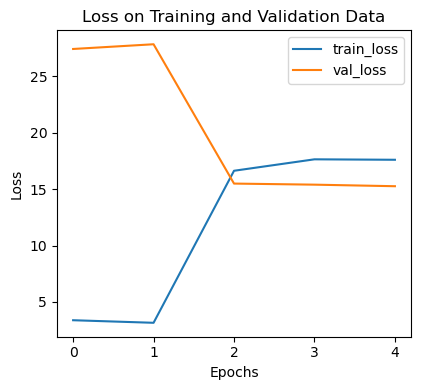

In [32]:
# 绘制训练/验证曲线
def training_vis(train_losses, valid_losses):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(train_losses, label='train_loss')
    ax1.plot(valid_losses,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    plt.tight_layout()
training_vis(train_losses, valid_losses)
